In [1]:
!curl -LO "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
!unzip human+activity+recognition+using+smartphones.zip
!unzip -qq "UCI HAR Dataset.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   157  100   157    0     0    362      0 --:--:-- --:--:-- --:--:--   362
Archive:  human+activity+recognition+using+smartphones.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of human+activity+recognition+using+smartphones.zip or
        human+activity+recognition+using+smartphones.zip.zip, and cannot find human+activity+recognition+using+smartphones.zip.ZIP, period.
replace UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss


from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))


## get the data from txt files to pandas dataffame
# training data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = features
X_train['Activity'] = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'])

# training labels
y_train_subject = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', names=['subject'])
X_train['subject'] = y_train_subject


# test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = features
X_test['Activity'] = pd.read_csv('UCI HAR Dataset/test/y_test.txt', names=['Activity'])

# test labels
y_test_subject = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', names=['Activity'])
X_test['subject'] = y_test_subject

# Combine both train and test data
all_X_data = pd.concat([X_train, X_test], axis=0)
all_X_data = all_X_data.reset_index(drop=True)

all_y_data = pd.concat([y_train_subject, y_test_subject], axis=0)
all_y_data = all_y_data.reset_index(drop=True)

# Split the test train data
subject_train, subject_test = train_test_split(all_X_data, test_size=0.2, random_state=42)

y_train = subject_train['subject']
X_train = subject_train.drop('subject', axis=1)

y_test = subject_test['subject']
X_test = subject_test.drop('subject', axis=1)

No of Features: 561


<ipython-input-1-db177353dd9a>:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-1-db177353dd9a>:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


In [9]:
# Reshape X_train to add the channel dimension required by Conv1D (batch_size, time_steps, features)
X_train_reshaped = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)

# Split the data into train and validation sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

# of the participants range from 0-29, needed for one hot encoding
y_train_split = y_train_split - 1
y_test_split = y_test_split - 1

# one hot encode y
y_train_split = to_categorical(y_train_split)
y_test_split = to_categorical(y_test_split)


# Define the model
model = Sequential()
model.add(Conv1D(filters=160, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(128, activation='relu'))

# Output layer (assuming binary classification, adjust accordingly for multi-class)
model.add(Dense(30, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_split, y_train_split, validation_data=(X_test_split, y_test_split), epochs=10, batch_size=32)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 206s 991ms/step - accuracy: 0.0525 - loss: 3.5125 - val_accuracy: 0.1657 - val_loss: 2.9611
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 260s 983ms/step - accuracy: 0.2443 - loss: 2.6733 - val_accuracy: 0.3981 - val_loss: 2.0969
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.4257 - loss: 1.9929 - val_accuracy: 0.5079 - val_loss: 1.7570
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5213 - loss: 1.6456 - val_accuracy: 0.5874 - val_loss: 1.4777
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 255s 987ms/step - accuracy: 0.5983 - loss: 1.3942 - val_accuracy: 0.6001 - val_loss: 1.3946
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6364 - loss: 1.2384 - val_accuracy: 0.6226 - val_loss: 1.3240
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 261s 997ms/step - accuracy: 0.6695 - loss: 1.0887 - val_accuracy: 0.6462 - val_loss: 1.1747
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7052 - loss: 0.977

In [12]:
 # Evaluate the model on validation data
test_loss, test_accuracy = model.evaluate(X_test_split, y_test_split)
print(f"Test Data Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7048 - loss: 1.0652
Test Data Loss: 1.076252818107605, Validation Accuracy: 0.6953883767127991


In [15]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 560, 160)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 280, 160)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 44800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1024)                │      45,876,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,035,804 (526.56 MB)

 Trainable params: 46,011,934 (175.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,023,870 (351.04 MB)

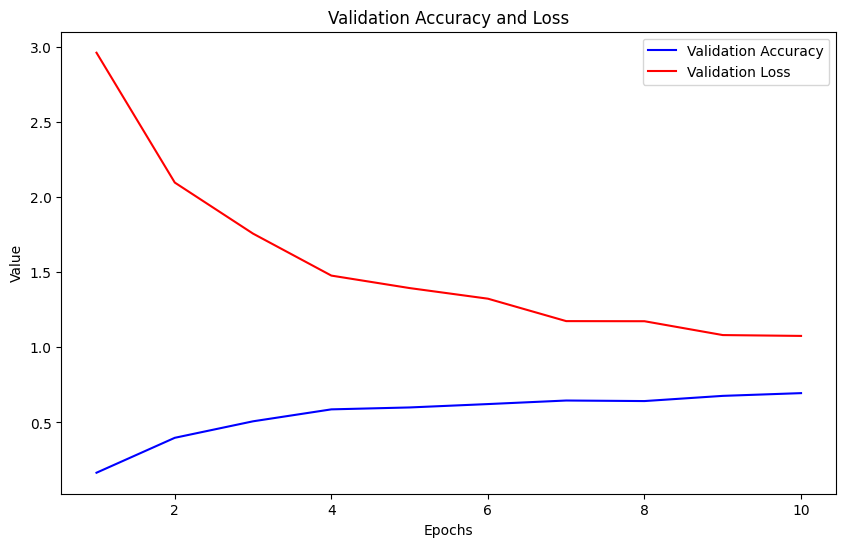

In [17]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step


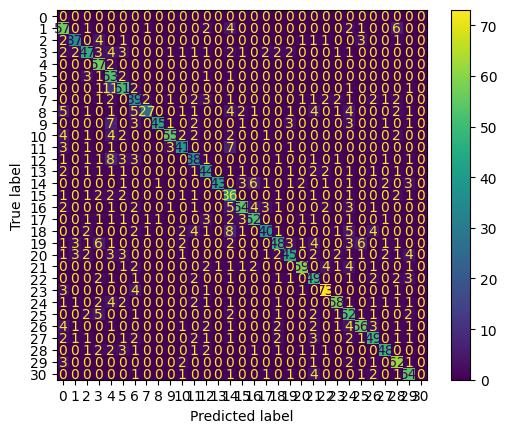

In [20]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(to_categorical(y_test), axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()